https://keras.io/examples/nlp/pretrained_word_embeddings/

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from Models import *
#Importing: BertEncodingWords, W2VModel

word_pairs, word_pairs_annotations = GetWordPairs()
word_list = GetWords()

dimensions = [10,20,30,40,50,60,70,80,90] + list(np.arange(100,800,100))

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# How Similar are BERT and Word2Vec?

In [4]:
from scipy.stats import spearmanr

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


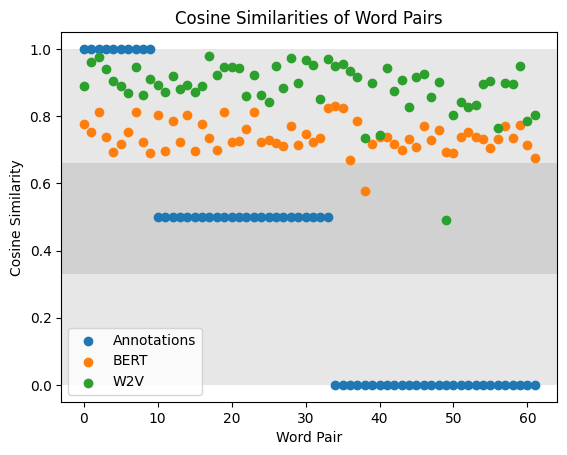

| Metrics | Rho  | P-Value |
| BERT:  | 0.12 | 0.34 |
| Word2Vec | 0.3  | 0.02 |


In [5]:
bertWords = BertEncodingWords()
W2V_768 = W2VModel(768)

BERT_similarities, W2V_similarities = [], []

for pair in word_pairs:
	BERT_similarities.append(1-cosine(bertWords.getWordVector(pair[0]), bertWords.getWordVector(pair[1])))
	W2V_similarities.append(1-cosine(W2V_768.getvector(pair[0]), W2V_768.getvector(pair[1])))


BERT_rho, BERT_p = spearmanr(word_pairs_annotations, BERT_similarities)
W2V_rho, W2V_p = spearmanr(word_pairs_annotations, W2V_similarities)
plt.scatter(np.arange(0,len(word_pairs_annotations)), word_pairs_annotations, label = "Annotations")
plt.scatter(np.arange(0,len(BERT_similarities)),BERT_similarities, label = "BERT")
plt.scatter(np.arange(0,len(W2V_similarities)),W2V_similarities, label = "W2V")
plt.axhspan(-0., 0.33, facecolor='0.1', alpha=0.1, zorder=0)
plt.axhspan(0.33, 0.66, facecolor='0.1', alpha=0.2, zorder=0)
plt.axhspan(0.66, 1.0, facecolor='0.1', alpha=0.1, zorder=0)
plt.title("Cosine Similarities of Word Pairs")
plt.xlabel("Word Pair")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.savefig("CosineSimilaritiesofWordPairs.png")
plt.show()

table = [["Metrics", "Rho", "P-Value"], ["BERT: ", np.round(BERT_rho, 2), np.round(BERT_p, 2)], ["Word2Vec", np.round(W2V_rho, 2), np.round(W2V_p, 2)]]
for row in table:
    print('| {:1} | {:^4} | {:<3} |'.format(*row))

# Rotations

In [6]:
def RotateWordVector(input_word_vector):
	rotated_word_vector = []
	for comaprison_word in word_list:
		rotated_word_vector.append(1-cosine(input_word_vector, W2V_768.getvector(comaprison_word)))
	return rotated_word_vector

W2V_768 = W2VModel(768)
rotated_words = dict()
for word in word_list:
	rotated_word_vector = []
	rotated_word_vector = RotateWordVector(W2V_768.getvector(word))
	normalized_rotated_vector = np.array(rotated_word_vector)
	scaled_normalized_rotated_vector = np.interp(normalized_rotated_vector, (normalized_rotated_vector.min(), normalized_rotated_vector.max()), (-1, +1))
	rotated_words.update({str(word): scaled_normalized_rotated_vector})

def evaluateSimilaritiesOfMethods():
	keys, res = [],[]
	for idx, word in enumerate(word_pairs):
		keys.append(str(word[0] + " "+ word[1]))
		res.append(1 - cosine(rotated_words[word[0]], rotated_words[word[1]]))
	return keys, res

keys, res = evaluateSimilaritiesOfMethods()

rotated_similatities_dict = {keys[i]: val for i, val in enumerate(res)}
#Below allows for repeated pairs
rotated_similatities = [rotated_similatities_dict[str(word[0] + " "+ word[1])] for word in word_pairs]

word = 'board'
comaprison_word = 'market'
1-cosine(W2V_768.getvector(word), W2V_768.getvector(comaprison_word)), 1-cosine(rotated_words[word], rotated_words[comaprison_word]), len(rotated_words['board']),len(rotated_words['market']) 

(0.9227846264839172, 0.9468292057114999, 138, 138)

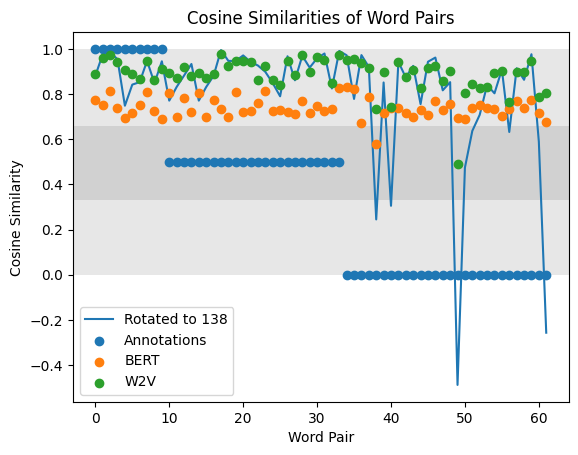

| Metrics | Rho  | P-Value |
| BERT:  | 0.12 | 0.34 |
| Word2Vec | 0.3  | 0.02 |
| Rotation | 0.33 | 0.01 |


In [7]:
plt.plot(rotated_similatities, label='Rotated to '+str(len(word_list)), zorder=1)
plt.scatter(np.arange(0,len(word_pairs_annotations)), word_pairs_annotations, label = "Annotations")
plt.scatter(np.arange(0,len(BERT_similarities)),BERT_similarities, label = "BERT")
plt.scatter(np.arange(0,len(W2V_similarities)),W2V_similarities, label = "W2V")
plt.axhspan(-0., 0.33, facecolor='0.1', alpha=0.1, zorder=0)
plt.axhspan(0.33, 0.66, facecolor='0.1', alpha=0.2, zorder=0)
plt.axhspan(0.66, 1.0, facecolor='0.1', alpha=0.1, zorder=0)
plt.title("Cosine Similarities of Word Pairs")
plt.xlabel("Word Pair")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.show()

Rotate_rho, Rotate_p = spearmanr(word_pairs_annotations, rotated_similatities)
table = [["Metrics", "Rho", "P-Value"],
 ["BERT: ", np.round(BERT_rho, 2), np.round(BERT_p, 2)],
 ["Word2Vec", np.round(W2V_rho, 2), np.round(W2V_p, 2)],
 ["Rotation", np.round(Rotate_rho, 2), np.round(Rotate_p, 2)]]
for row in table:
    print('| {:1} | {:^4} | {:<3} |'.format(*row))

# Single Value Decomposition

https://en.wikipedia.org/wiki/Singular_value_decomposition#:~:text=equivalent%20to%20zero.-,Low%2Drank%20matrix%20approximation,-%5Bedit%5D


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD

In [8]:
def PerformSVD(A, N):
    # Perform SVD on the input vector
    U, D, Vt = np.linalg.svd(A)
    print(U.shape, D.shape, Vt.shape)
    # Select the first N columns of the U matrix
    U_reduced = U[:, :N]
    # Multiply the reduced U matrix with the S matrix
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

PerformSVD(np.array([[2,3, 9, 9, 9, 34,5, 4,5,6,44,5,6,4,3,9]]),1)

(1, 1) (1,) (16, 16)


array([[-60.14149982]])

# PCA

In [9]:
from sklearn.decomposition import PCA

def DimReduceByPCA(input_array, new_dims):
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca
	

word_vectors = np.array([W2V_768.getvector(vec) for vec in word_list])#np.array([bertWords.getWordVector(vec) for vec in word_list])
PCA_vec = DimReduceByPCA(word_vectors, 138)
assert(np.array(word_vectors).shape[0] == PCA_vec.shape[0])

dict_PCA_vec = {word_list[i]: row for i, row in enumerate(PCA_vec)}

assert(np.array(word_vectors).shape[0] == PCA_vec.shape[0])

PCA_vec=[]
for pair in word_pairs:
	PCA_vec.append(1-cosine(dict_PCA_vec[pair[0]],dict_PCA_vec[pair[1]]))


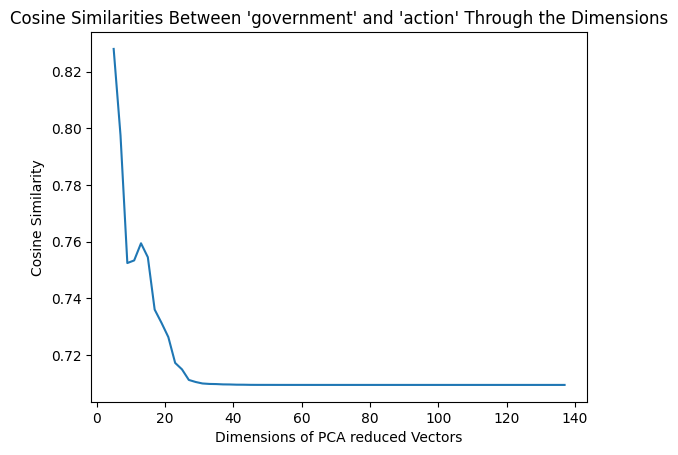

In [10]:
def PlotPCAThroughDims(word1, word2):
	sims = []
	plot_xaxis = np.arange(5,138,2)
	for dims in plot_xaxis:
		word_vectors = np.array([W2V_768.getvector(vec) for vec in word_list])#np.array([bertWords.getWordVector(vec) for vec in word_list])
		PCA_vec = DimReduceByPCA(word_vectors, dims)
		dict_PCA_vec = {word_list[i]: row for i, row in enumerate(PCA_vec)}
		sims.append(1-cosine(dict_PCA_vec[word1],dict_PCA_vec[word2]))
	dot_prods = np.array(sims)

	plt.plot(plot_xaxis, dot_prods)
	plt.title("Cosine Similarities Between '"+ word1+ "' and '"+ word2+ "' Through the Dimensions")
	plt.ylabel("Cosine Similarity")
	plt.xlabel("Dimensions of PCA reduced Vectors")
	plt.savefig('Cosine_Similarities_Between_'+ word1+ '_and_'+ word2+ '_Through_the_Dimensions.png')
	plt.show()
	return
PlotPCAThroughDims('government', 'action')

C:\Users\henry\AppData\Local\Temp\ipykernel_37484\2212561758.py:21: RuntimeWarning: divide by zero encountered in log
  plt.plot(dimensions, np.log(dim_similarities.T))


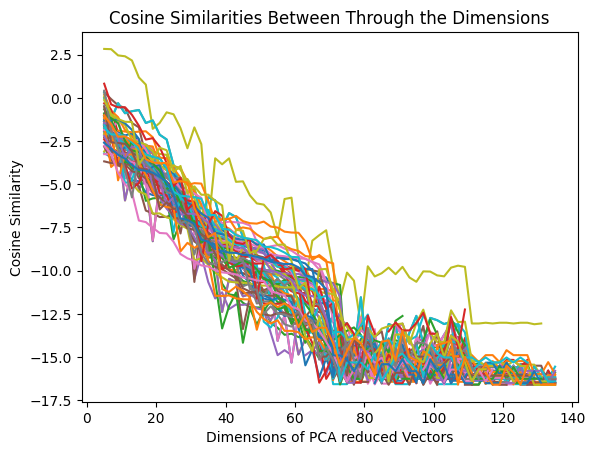

In [11]:
def PlotPCAThroughDims():
	model = np.array([W2V_768.getvector(vec) for vec in word_list])#np.array([bertWords.getWordVector(vec) for vec in word_list])
	dim_similarities = []
	dimensions = np.arange(5,138,2)
	for dims in dimensions:
		dim_specific_similarities = []
		PCA_vec = DimReduceByPCA(word_vectors, dims)
		dict_PCA_vec = {word_list[i]: row for i, row in enumerate(PCA_vec)}
		for pair in word_pairs:
			dim_specific_similarities.append(1-cosine(dict_PCA_vec[pair[0]],dict_PCA_vec[pair[1]]))
		dim_similarities.append(dim_specific_similarities)
	dim_similarities = np.array(dim_similarities).T #Transpose makes the first index a series of similarities for the same word pair through dimensions

	#Scale similarities to get absolute error from 138 dims
	for pair_index, pair_similarity_series in enumerate(dim_similarities):
		for sim_index, sim in enumerate(pair_similarity_series):
			if sim_index == len(pair_similarity_series)-1: dim_similarities[pair_index, sim_index] = 0
			else:
				dim_similarities[pair_index, sim_index] = abs((sim - dim_similarities[pair_index, -1]) / dim_similarities[pair_index, -1])

	plt.plot(dimensions, np.log(dim_similarities.T))
	plt.title("Cosine Similarities Between Through the Dimensions")
	plt.ylabel("Cosine Similarity")
	plt.xlabel("Dimensions of PCA reduced Vectors")
	plt.savefig('Cosine_Similarities_Between_Through_the_Dimensions.png')
	return dim_similarities

array_of_res = PlotPCAThroughDims()

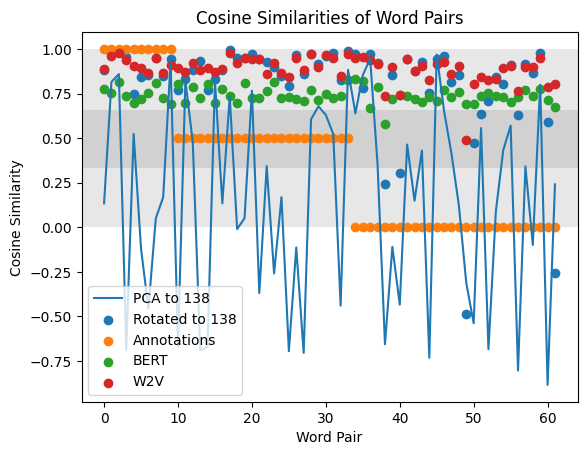

| Metrics | Rho  | P-Value |
| BERT:  | 0.12 | 0.34 |
| Word2Vec | 0.3  | 0.02 |
| Rotation | 0.33 | 0.01 |
| PCA | 0.04 | 0.77 |


In [12]:
plt.plot(PCA_vec, label = 'PCA to '+str(138))
plt.scatter(np.arange(0,len(rotated_similatities)),rotated_similatities, label='Rotated to '+str(len(word_list)))
plt.scatter(np.arange(0,len(word_pairs_annotations)), word_pairs_annotations, label = "Annotations")
plt.scatter(np.arange(0,len(BERT_similarities)),BERT_similarities, label = "BERT")
plt.scatter(np.arange(0,len(W2V_similarities)),W2V_similarities, label = "W2V")
plt.axhspan(-0., 0.33, facecolor='0.1', alpha=0.1, zorder=0)
plt.axhspan(0.33, 0.66, facecolor='0.1', alpha=0.2, zorder=0)
plt.axhspan(0.66, 1.0, facecolor='0.1', alpha=0.1, zorder=0)
plt.title("Cosine Similarities of Word Pairs")
plt.xlabel("Word Pair")
plt.ylabel("Cosine Similarity")
plt.legend()
#plt.savefig("Cosine_Similarities_of_Word_Pairs.png")
plt.show()
#PCA takes away the mean of each feature (scaling to mean = 0)
#Multiply by transpose to make positive, gives row embedding with positive numbers.

PCA_rho, PCA_p = spearmanr(word_pairs_annotations, PCA_vec)
table = [["Metrics", "Rho", "P-Value"],
 ["BERT: ", np.round(BERT_rho, 2), np.round(BERT_p, 2)],
 ["Word2Vec", np.round(W2V_rho, 2), np.round(W2V_p, 2)],
 ["Rotation", np.round(Rotate_rho, 2), np.round(Rotate_p, 2)],
 ["PCA", np.round(PCA_rho, 2), np.round(PCA_p, 2)]]
for row in table:
    print('| {:1} | {:^4} | {:<3} |'.format(*row))

# Autoencoder (Symetric & Deep)

In [13]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [14]:
encoding_dim = 15 
input_img = Input(shape=(768,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# decoded representation of code 
decoded1 = Dense(768, activation='sigmoid')(encoded)
decoded2 = Dense(384, activation='sigmoid')(encoded)
decoded3 = Dense(96, activation='sigmoid')(encoded)
decoded4 = Dense(20, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_img, [decoded1, decoded2, decoded3, decoded4])

# This model shows encoded images
encoder = Model(input_img, encoded)
# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Evaluation: Similarities in Methods

In [16]:
BERT = BertEncodingWords(word_list)
W2V = W2VModel(768)

BERT_dots = dict()
W2V_dots = dict()
ROTATED_dots = dict()
for pair in word_pairs:
	print(pair)
	#Try accept as some words do not work in the W2V eg:W2V.wv['plan'] -> Error
	W2V_dots.update({pair[0]+" "+pair[1]:1 - cosine(W2V.getvector(pair[0]), W2V.getvector(pair[1]))})
	ROTATED_dots.update({pair[0]+" "+pair[1]:1 - cosine(rotated_words[pair[0]], rotated_words[pair[1]])})
	BERT_dots.update({pair[0]+" "+pair[1]:1 - cosine(BERT.getWordVector(pair[0]), BERT.getWordVector(pair[1]))})
	#print(pair[0], pair[1], len(BERT_dots), len(W2V_dots), np.round(W2V_dots[pair[0]+" "+pair[1]], 2), np.round(BERT_dots[pair[0]+" "+pair[1]], 2))

TypeError: BertEncodingWords.__init__() takes 1 positional argument but 2 were given

In [ ]:
BERT_dots

{'party government': 0.7750695943832397,
 'official leader': 0.7522398829460144,
 'state government': 0.8133704662322998,
 'control intervention': 0.7376946806907654,
 'tax interest': 0.6943225264549255,
 'charge rate': 0.717332661151886,
 'party opposition': 0.7518858313560486,
 'leader member': 0.8111140727996826,
 'tax family': 0.7233424186706543,
 'credit allowance': 0.691547691822052,
 'state county': 0.8042483925819397,
 'benefit council': 0.6971415281295776,
 'state town': 0.7847762107849121,
 'control council': 0.7227463722229004,
 'government party': 0.7750695943832397,
 'intervention leader': 0.735630452632904,
 'market board': 0.6992111802101135,
 'labour housing': 0.722057580947876,
 'cost benefit': 0.7255298495292664,
 'management computer': 0.7612450122833252,
 'structure system': 0.8126272559165955,
 'family tax': 0.7233424186706543,
 'allowance rate': 0.7304175496101379,
 'tax wage': 0.7193946838378906,
 'credit increase': 0.7105820178985596,
 'management planning': 0.7

NameError: name 'BERT_dots' is not defined

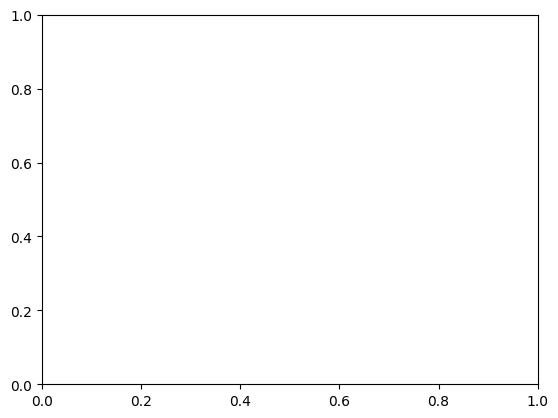

In [17]:
fig, ax = plt.subplots()

plt.plot(BERT_dots.values(), color='g', label = 'BERT')
plt.plot(W2V_dots.values(), label = 'W2V')
plt.plot(ROTATED_dots.values(), label = 'Rotate')
plt.legend()
plt.show()